     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.1 MB/s eta 0:00:00
Using device: cuda
Total commits: 1481
Total files: 8420
Avg files per commit: 5.69
Fix type distribution:
 LLM Inference
update engine.py in engine.py                          59
update config.py in config.py                          26
update checkpointing.py in checkpointing.py            19
update cpu_adam.py in cpu_adam.py                      17
update auto_tp.py in auto_tp.py                        16
update pipeline_engine.py in engine.py                 15
add missing description in __init__.py                 15
update replace_module.py in replace_module.py          14
add note about imperative style in requirements.txt    12
add tests for deepspeed in engine.py                   12
Name: count, dtype: int64
Most common file extensions:
 Fil

  0%|          | 0/8420 [00:00<?, ?it/s]

Radon metrics saved: /content/lab3_checkpoints/radon_metrics.csv


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Computing Semantic & Token Similarity...


  0%|          | 0/527 [00:00<?, ?it/s]

Embeddings & similarity saved.

Agreement counts:
 Classes_Agree
YES    7879
NO      541
Name: count, dtype: int64

Semantic Class counts:
 Semantic_Class
Minor    7157
Major    1263
Name: count, dtype: int64

Token Class counts:
 Token_Class
Minor    6616
Major    1804
Name: count, dtype: int64
Lab 3 final dataset saved: /content/lab3_bug_metrics_final.csv


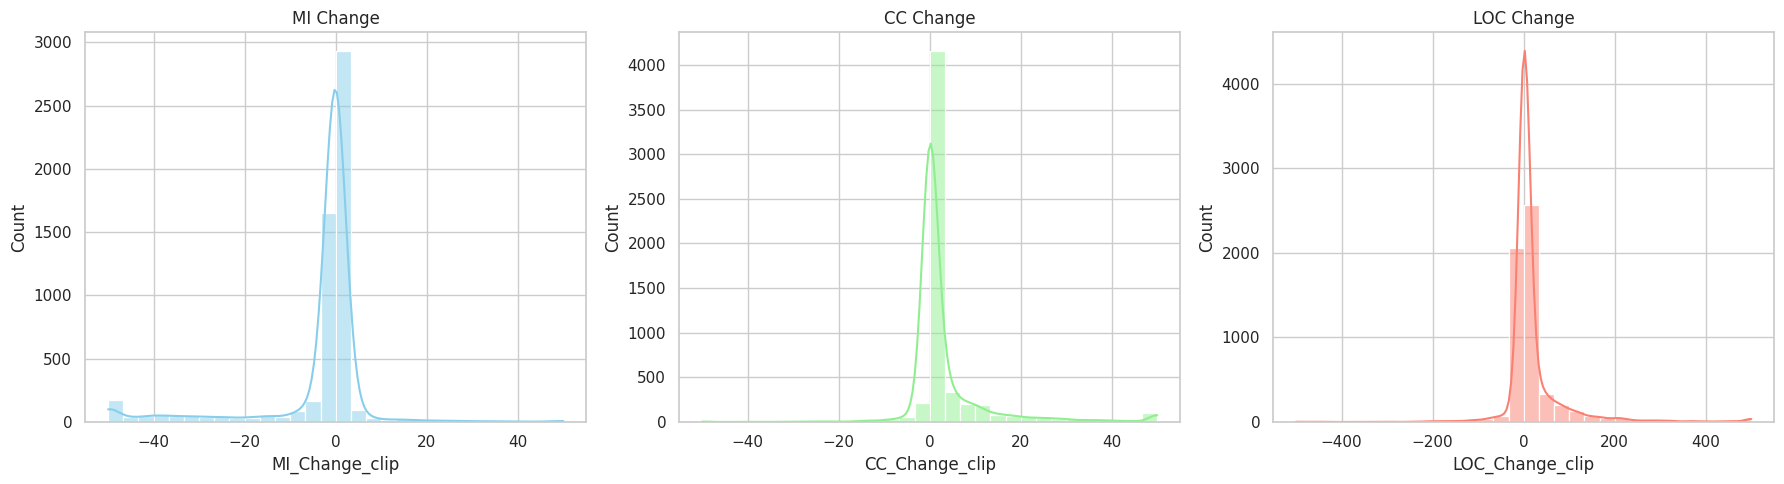

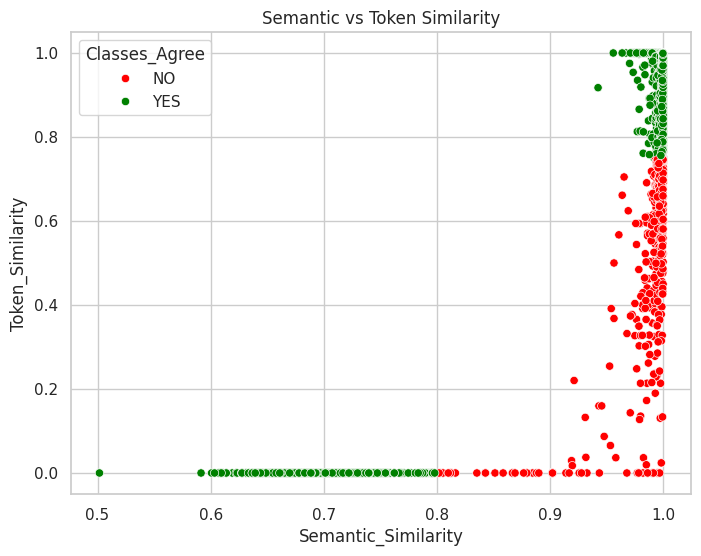

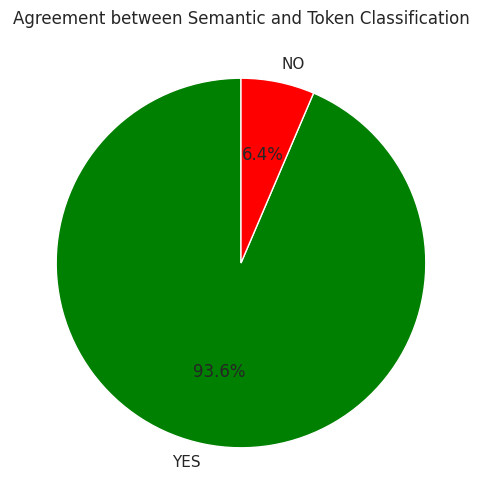


--- Sanity Check: Semantic & Token Similarity Ranges ---
Semantic Similarity: min = 0.5016905069351196 , max = 1.000000238418579
Token Similarity: min = 0.0 , max = 1.0000000000000004

--- Sanity Check: Change Metrics (Python files) ---
MI Change: min = -100.0 , max = 82.50989689839646
CC Change: min = -187.0 , max = 522.0
LOC Change: min = -1423.0 , max = 2831.0


In [ ]:
# === Lab 3: Multi-Metric Bug Context Analysis (Clean Version) ===

# --- Install dependencies ---
!pip install -q radon sacrebleu transformers torch tqdm sentence-transformers pandas matplotlib seaborn

# --- Imports ---
import os, warnings
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from radon.complexity import cc_visit
from radon.metrics import mi_visit
from radon.raw import analyze
from sentence_transformers import SentenceTransformer
import sacrebleu
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# --- Directories ---
CHECKPOINT_DIR = "/content/lab3_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- Load Lab 2 CSV dataset ---
lab2_file = "/content/rectified_commits.csv"  # Upload your file
df = pd.read_csv(lab2_file)

# --- Baseline statistics ---
print(f"Total commits: {df['Hash'].nunique()}")
print(f"Total files: {len(df)}")
print(f"Avg files per commit: {df.groupby('Hash')['Filename'].count().mean():.2f}")
print("Fix type distribution:\n", df["LLM Inference"].value_counts().head(10))
print("Most common file extensions:\n", df["Filename"].apply(lambda x: os.path.splitext(x)[1]).value_counts().head(10))

# --- Stage (c) Radon Metrics for Python files only ---
def compute_radon_metrics(code, filename):
    """Compute MI, CC, LOC safely for Python files"""
    if not str(filename).endswith(".py") or not str(code).strip():
        return np.nan, np.nan, np.nan
    try:
        code = str(code)
        mi = mi_visit(code, True)
        cc_items = cc_visit(code)
        cc_sum = sum([c.complexity for c in cc_items]) if cc_items else 0
        loc = analyze(code).loc
        return mi, cc_sum, loc
    except:
        return np.nan, np.nan, np.nan

radon_checkpoint = os.path.join(CHECKPOINT_DIR, "radon_metrics.csv")
if os.path.exists(radon_checkpoint):
    print("Loading Radon metrics from checkpoint...")
    df_radon = pd.read_csv(radon_checkpoint)
    for col in ["MI_Before","CC_Before","LOC_Before","MI_After","CC_After","LOC_After",
                "MI_Change","CC_Change","LOC_Change"]:
        if col in df_radon.columns:
            df[col] = df_radon[col]
else:
    print("Computing Radon metrics for Python files...")
    mi_before, cc_before, loc_before = [], [], []
    mi_after, cc_after, loc_after = [], [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        mi_b, cc_b, loc_b = compute_radon_metrics(row["Source Code (before)"], row["Filename"])
        mi_a, cc_a, loc_a = compute_radon_metrics(row["Source Code (current)"], row["Filename"])
        mi_before.append(mi_b); cc_before.append(cc_b); loc_before.append(loc_b)
        mi_after.append(mi_a); cc_after.append(cc_a); loc_after.append(loc_a)
    df["MI_Before"], df["CC_Before"], df["LOC_Before"] = mi_before, cc_before, loc_before
    df["MI_After"], df["CC_After"], df["LOC_After"] = mi_after, cc_after, loc_after
    df["MI_Change"] = df["MI_After"] - df["MI_Before"]
    df["CC_Change"] = df["CC_After"] - df["CC_Before"]
    df["LOC_Change"] = df["LOC_After"] - df["LOC_Before"]
    df.to_csv(radon_checkpoint, index=False)
    print(f"Radon metrics saved: {radon_checkpoint}")

# --- Stage (d) Semantic & Token Similarity ---
def safe_tokenize(code):
    code_str = str(code).strip()
    return code_str.split() if code_str else ["<EMPTY>"]

def compute_token_similarity(before, after):
    try:
        return sacrebleu.sentence_bleu(" ".join(safe_tokenize(after)),
                                       [" ".join(safe_tokenize(before))]).score / 100.0
    except:
        return 0.0

embedding_checkpoint = os.path.join(CHECKPOINT_DIR, "embeddings_similarity.csv")
BATCH_SIZE = 16
sbert_model = SentenceTransformer('microsoft/codebert-base', device=device)

if os.path.exists(embedding_checkpoint):
    print("Loading embeddings & similarity from checkpoint...")
    df_emb = pd.read_csv(embedding_checkpoint)
    df["Semantic_Similarity"] = df_emb["Semantic_Similarity"]
    df["Token_Similarity"] = df_emb["Token_Similarity"]
else:
    print("Computing Semantic & Token Similarity...")
    semantic_sims, token_sims = [], []
    for i in tqdm(range(0, len(df), BATCH_SIZE)):
        batch = df.iloc[i:i+BATCH_SIZE]
        codes = []
        for _, row in batch.iterrows():
            codes.append(str(row["Source Code (before)"]))
            codes.append(str(row["Source Code (current)"]))
        embeddings = sbert_model.encode(codes, convert_to_tensor=True)
        for j in range(0, len(embeddings), 2):
            cos_sim = torch.nn.functional.cosine_similarity(embeddings[j], embeddings[j+1], dim=0)
            semantic_sims.append(float(cos_sim))
        for _, row in batch.iterrows():
            token_sims.append(compute_token_similarity(row["Source Code (before)"],
                                                       row["Source Code (current)"]))
    df["Semantic_Similarity"] = semantic_sims
    df["Token_Similarity"] = token_sims
    df.to_csv(embedding_checkpoint, index=False)
    print("Embeddings & similarity saved.")

# --- Stage (e) Classification & Agreement ---
SEM_THRESHOLD, TOKEN_THRESHOLD = 0.80, 0.75
df["Semantic_Class"] = df["Semantic_Similarity"].apply(lambda x: "Minor" if x >= SEM_THRESHOLD else "Major")
df["Token_Class"]    = df["Token_Similarity"].apply(lambda x: "Minor" if x >= TOKEN_THRESHOLD else "Major")
print("\nSemantic Class counts:\n", df["Semantic_Class"].value_counts())
print("\nToken Class counts:\n", df["Token_Class"].value_counts())

df["Classes_Agree"]  = df.apply(lambda row: "YES" if row["Semantic_Class"] == row["Token_Class"] else "NO", axis=1)
print("\nAgreement counts:\n", df["Classes_Agree"].value_counts())


# --- Filter Python files for structural analysis ---
df_py = df[df['Filename'].str.endswith('.py')].copy()

# Clip extreme values for plots (optional)
df_py['LOC_Change_clip'] = df_py['LOC_Change'].clip(-500, 500)
df_py['CC_Change_clip'] = df_py['CC_Change'].clip(-50, 50)
df_py['MI_Change_clip'] = df_py['MI_Change'].clip(-50, 50)

# --- Save final dataset ---
final_file = "/content/lab3_bug_metrics_final.csv"
df.to_csv(final_file, index=False)
print(f"Lab 3 final dataset saved: {final_file}")

# --- Visualizations ---
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(df_py["MI_Change_clip"].dropna(), bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("MI Change")
sns.histplot(df_py["CC_Change_clip"].dropna(), bins=30, kde=True, ax=axes[1], color="lightgreen")
axes[1].set_title("CC Change")
sns.histplot(df_py["LOC_Change_clip"].dropna(), bins=30, kde=True, ax=axes[2], color="salmon")
axes[2].set_title("LOC Change")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x="Semantic_Similarity", y="Token_Similarity", hue="Classes_Agree", data=df,
                palette={"YES":"green","NO":"red"})
plt.title("Semantic vs Token Similarity")
plt.show()

agree_counts = df["Classes_Agree"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(agree_counts, labels=agree_counts.index, autopct="%1.1f%%", colors=["green","red"], startangle=90)
plt.title("Agreement between Semantic and Token Classification")
plt.show()

# --- Sanity Checks ---
print("\n--- Sanity Check: Semantic & Token Similarity Ranges ---")
print("Semantic Similarity: min =", df["Semantic_Similarity"].min(),
      ", max =", df["Semantic_Similarity"].max())
print("Token Similarity: min =", df["Token_Similarity"].min(),
      ", max =", df["Token_Similarity"].max())

print("\n--- Sanity Check: Change Metrics (Python files) ---")
print("MI Change: min =", df_py["MI_Change"].min(), ", max =", df_py["MI_Change"].max())
print("CC Change: min =", df_py["CC_Change"].min(), ", max =", df_py["CC_Change"].max())
print("LOC Change: min =", df_py["LOC_Change"].min(), ", max =", df_py["LOC_Change"].max())
